In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/ismael/Utils/miniconda2/envs/fastai2/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
#hide
from fastbook import *

# Séance 1

## Premier modèle

En exécutant la cellule ci-dessous:
1. Un jeu de données appelé [Oxford-IIIT Pet Dataset] qui contient 7 349 images de chats et de chiens de 37 races différentes sera téléchargé de la collection de jeux de données fast.ai vers le serveur GPU que vous utilisez, puis extrait.

1. Un jeu de données appelé [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) qui contient 7 349 images de chats et de chiens de 37 races différentes sera téléchargé de la collection de jeux de données fast.ai vers le serveur GPU que vous utilisez, puis extrait.
2. Un *modèle pré-entraîné* sur 1,3 million d'images, en utilisant un modèle gagnant d'une compétition (ImageNet), sera téléchargé.
3. Le modèle pré-entraîné sera *affiné - fine_tune -* en utilisant les dernières avancées de l'apprentissage par transfert, pour créer un modèle spécialement personnalisé pour reconnaître les chiens et les chats.

Les deux premières étapes ne seront exécutées qu'une seule fois sur votre serveur GPU. Si vous exécutez à nouveau la cellule, elle utilisera l'ensemble de données et le modèle qui ont déjà été téléchargés, plutôt que de les télécharger à nouveau. Jetons un coup d'œil au contenu de la cellule et aux résultats (<<first_training>>):

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.156533,0.015568,0.005413,10:47


epoch,train_loss,valid_loss,error_rate,time
0,0.059592,0.026710,0.006766,14:16


Vous ne verrez probablement pas exactement les mêmes résultats que ci-dessus. Il existe de nombreuses sources de petites variations aléatoires impliquées dans les modèles d'apprentissage.

> **important:** Durée d'apprentissage: en fonction de la vitesse de votre réseau, cela peut prendre quelques minutes pour le téléchargement du modèle  pré-entraînés et du jeu de données. L'exécution de `fine_tune` peut prendre environ une minute. Souvent, les modèles prennent quelques minutes ou, bien plus à s'entraîner. C'est donc une bonne idée de trouver de bonnes techniques pour tirer le meilleur parti de ce temps. Par exemple, continuez à lire la section suivante pendant que votre modèle s'entraîne, ou ouvrez un autre notebook et utilisez-le pour le codage d'autres expériences.

In [4]:
learn.save("resnet18_chats_chiens")
# learn.load("resnet18_chats_chiens")

Path('/home/ismael/.fastai/data/oxford-iiit-pet/images/models/resnet18_chats_chiens.pth')

### Evaluation du modèle

Alors, comment savoir si ce modèle est bon? Dans la dernière colonne du tableau, vous pouvez voir le taux d'erreur, qui est la proportion d'images incorrectement identifiées. Le taux d'erreur sert de mesure - notre mesure de la qualité du modèle, choisie pour être intuitive et compréhensible. Comme vous pouvez le voir, le modèle est presque parfait, même si le temps d'apprentissage n'était que de quelques secondes (sans compter le téléchargement unique de l'ensemble de données et du modèle pré-entraîné). En fait, la précision que vous avez déjà obtenue est bien meilleure que quiconque n'avait jamais atteint il y a à peine 10 ans!

Enfin, vérifions que ce modèle fonctionne réellement. Allez chercher une photo d'un chien ou d'un chat; si vous n'en avez pas sous la main, recherchez simplement Google Images et téléchargez une image que vous y trouvez. Exécutez maintenant la cellule avec `uploader` défini. Il affichera un bouton sur lequel vous pouvez cliquer, afin que vous puissiez sélectionner l'image que vous souhaitez classer:

In [7]:
#hide_output
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" id="upload" src="images/att_00008.png">

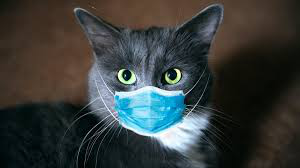

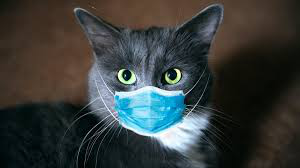

In [8]:
img = PILImage.create(uploader.data[0])
display(img)
img

Vous pouvez maintenant transmettre le fichier téléchargé au modèle. Assurez-vous qu'il s'agit d'une photo claire d'un seul chien ou d'un chat, et non d'un dessin au trait, d'un dessin animé ou similaire. Le cahier vous dira s'il pense que c'est un chien ou un chat et à quel point il est confiant. J'espère que vous constaterez que votre modèle a fait un excellent travail.

In [9]:
is_cat,_,probs = learn.predict(img)
print(f"Est-ce un chat?: {'Oui' if is_cat else 'Non'}.")
print(f"Probabilité que c'est un chat: {probs[1].item():.6f}")

Est-ce un chat?: Oui.
Probabilité que c'est un chat: 1.000000


Félicitations pour votre premier classifieur profond!

mais qu'est ce que ça veut dire? Qu'avez-vous fait réellement? 

Afin d'expliquer cela, faisons à nouveau un zoom arrière pour avoir une vue d'ensemble.

###  Principe du Machine Learning?

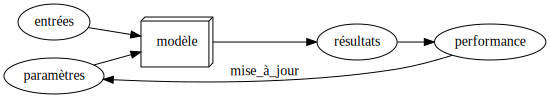

In [32]:
#hide_input
#caption Training a machine learning model
#id training_loop
#alt The basic training loop
gv('''ordering=in
modèle[shape=box3d width=1 height=0.7]
entrées->modèle->résultats; paramètres->modèle; résultats->performance
performance->paramètres[constraint=false label=mise_à_jour]''')

Chaque algorithme d'apprentissage automatique est caractérisé par:
1. la structure du **modèle**, 
1. la mesure **performance** utilisée
1. son mécanisme de **mise-à-jour** de ses paramètres

Pour un NN, nous avons le schéma

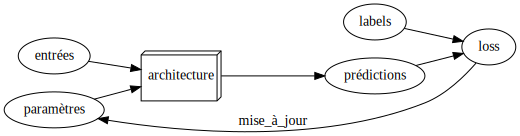

In [10]:
#hide_input
#caption Detailed training loop
#id detailed_loop
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
entrées->model->prédictions; paramètres->model; labels->loss; prédictions->loss
loss->paramètres[constraint=false label=mise_à_jour]''')

Nous verrons par la suite l'architecture utilisée dans notre classifieur. Ici *loss* correspond à la fonction mesurant la performance (jargon du DL). Ces deux dépendent de la tâche à réaliser.


Le mécanisme de *mise_à_jour* est le SGD ou descente du gradient stochastique.
Elle permet de trouver automatiquement le jeu de paramètres permettant au modèle de réaliser correctement la tâche assignée à savoir reconnaître les chats et chiens.
Cette méthode fonctionne quelque soit la tâche à accomplir, l'architecture et le *loss*.

Nous verrons par la suite en détail ces composantes.

### Limitations Inherentes au Machine Learning

À partir de cette image, nous pouvons maintenant voir certaines choses fondamentales sur l'entraînement d'un modèle d'apprentissage profond:

- Un modèle ne peut pas être créé sans données.
- Un modèle ne peut apprendre à opérer que sur les entrées similaires à celles  utilisées pour l'entraîner.
- Cette approche d'apprentissage ne crée que des *prédictions*, et non des *actions*  recommandées.
- Il ne suffit pas d'avoir des exemples de données d'entrée; nous avons également besoin *d'étiquettes* pour ces données (par exemple, les images de chiens et de chats ne suffisent pas pour former un modèle; nous avons besoin d'une étiquette pour chacun d'eux, indiquant lesquels sont des chiens et lesquels sont des chats).

De manière générale, nous avons vu que la plupart des organisations **qui déclarent ne pas disposer de suffisamment de données voulant dire en fait qu'elles ne disposent pas de suffisamment de données *étiquetées***. Si une organisation est intéressée à faire quelque chose dans la pratique avec un modèle, alors il est probable qu'elle ait des données d'entrée sur lesquelles elle prévoit d'exécuter son modèle. Et vraisemblablement, elle le fait d'une autre manière depuis un certain temps (par exemple, manuellement ou avec un programme d'heuristiques), donc elle a des données de ces processus! Par exemple, un cabinet de radiologie aura presque certainement une archive de scans médicaux (car ils doivent pouvoir vérifier la progression de leurs patients au fil du temps), mais ces scans peuvent ne pas avoir d'étiquettes structurées contenant une liste de diagnostics ou d'interventions (étant donnée que les radiologues créent généralement des rapports en langage naturel en texte libre, et non des données structurées). Nous discuterons beaucoup des approches d'étiquetage dans ce livre, car c'est une question très importante dans la pratique.

Étant donné que ces types de modèles d'apprentissage automatique ne peuvent faire que des *prédictions* (c'est-à-dire tenter de répliquer des étiquettes), cela peut entraîner un écart important entre les objectifs organisationnels et les capacités du modèle. Par exemple, dans ce livre, vous apprendrez à créer un *système de recommandation* qui peut prédire les produits qu'un utilisateur peut acheter. Ceci est souvent utilisé dans le commerce électronique, par exemple pour personnaliser les produits affichés sur une page d'accueil en affichant les articles les mieux classés. Mais un tel modèle est généralement créé en regardant un utilisateur et son historique d'achat (*entrées*) et ce qu'il a ensuite acheté ou regardé (*étiquettes*), ce qui signifie que le modèle est susceptible de vous indiquer des produits l'utilisateur déjà acquis ou connu, plutôt que de nouveaux produits dont il est le plus susceptible d'être intéressé à entendre parler. C'est très différent de ce que, disons, un expert de votre libraire local pourrait faire, où il pose des questions pour déterminer votre goût, puis vous parle d'auteurs ou de séries dont vous n'avez jamais entendu parler auparavant.

Maintenant que vous avez vu la base de la théorie, revenons à notre exemple de code et voyons en détail comment le code correspond au processus que nous venons de décrire.

### Fonctionnement de notre outil de reconnaissance d'images

Voyons comment notre code de reconnaissance d'image correspond à ces idées. Nous allons mettre chaque ligne dans une cellule séparée et regarder ce que chacun fait (nous n'expliquerons pas encore tous les détails de chaque paramètre, mais donnerons une description des éléments importants; tous les détails viendront plus tard dans le livre ).

La première ligne importe toute la bibliothèque fastai.vision.


```python
from fastai.vision.all import *
```

Cela nous donne toutes les fonctions et classes dont nous aurons besoin pour créer une grande variété de modèles de vision par ordinateur.

> J: De nombreux codeurs Python recommandent d'éviter d'importer une bibliothèque entière comme celle-ci (en utilisant la syntaxe `import *`), car dans les grands projets logiciels, cela peut causer des problèmes. Cependant, pour un travail interactif comme dans un notebook Jupyter, cela fonctionne très bien. La bibliothèque fastai est spécialement conçue pour prendre en charge ce type d'utilisation interactive, et elle n'importera que les éléments nécessaires dans votre environnement.

La deuxième ligne télécharge un ensemble de données standard de la [collection d'ensembles de données fast.ai] (https://course.fast.ai/datasets) (s'il n'a pas été téléchargé précédemment) sur votre serveur, l'extrait (s'il n'a pas été précédemment extrait) et renvoie un objet `Path` avec l'emplacement extrait:

```python
path = untar_data(URLs.PETS)/'images'
```

> S: Tout au long de mes études sur fast.ai, et même encore aujourd'hui, j'ai beaucoup appris sur les pratiques de codage productives. La bibliothèque fastai et les notebooks fast.ai regorgent de petits conseils qui ont contribué à faire de moi un meilleur programmeur. Par exemple, notez que la bibliothèque fastai ne renvoie pas seulement une chaîne contenant le chemin d'accès à l'ensemble de données, mais un objet `Path`. Il s'agit d'une classe très utile de la bibliothèque standard Python 3 qui facilite grandement l'accès aux fichiers et aux répertoires. Si vous ne l'avez pas encore rencontré, assurez-vous de consulter sa documentation ou un tutoriel et de l'essayer. Notez que le https://book.fast.ai [site Web] contient des liens vers des didacticiels recommandés pour chaque chapitre. Je continuerai de vous informer des petits conseils de codage que j'ai trouvés utiles au fur et à mesure que nous les rencontrons.

Dans la troisième ligne, nous définissons une fonction, `is_cat`, qui étiquette les chats en fonction d'une règle basée sur le nom du fichier fourni par les constructeurs de l'ensemble de données:
```python
def is_cat(x): return x[0].isupper()
```

Nous utilisons cette fonction dans la quatrième ligne, qui indique à fastai quel type de jeu de données nous avons et comment il est structuré:

```python
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

Il existe différentes classes pour différents types d'ensembles de données et de problèmes d'apprentissage profond - ici, nous utilisons `ImageDataLoaders`. La première partie du nom de la classe sera généralement le type de données dont vous disposez, comme une image ou du texte.

L'autre information importante que nous devons fournir à fastai est de savoir comment obtenir les étiquettes de l'ensemble de données. Les ensembles de données de vision par ordinateur sont normalement structurés de telle manière que l'étiquette d'une image fait partie du nom de fichier ou du chemin, le plus souvent le nom du dossier parent. fastai fournit un certain nombre de méthodes d'étiquetage standardisées et des moyens d'écrire les vôtres. Ici, nous disons à fastai d'utiliser la fonction `is_cat` que nous venons de définir.

Enfin, nous définissons les «Transform» dont nous avons besoin. Une «Transform» contient du code qui est appliqué automatiquement pendant l'entraînement; fastai inclut de nombreux `Transform`s prédéfinis, et en ajouter de nouveaux est aussi simple que de créer une fonction Python. Il existe deux types: `item_tfms` est appliqué à chaque élément (dans ce cas, chaque élément est redimensionné en un carré de 224 pixels), tandis que` batch_tfms` est appliqué à un *batch ou lot* d'éléments à la fois en utilisant le GPU, ils sont donc particulièrement rapides (nous en verrons de nombreux exemples tout au long de ce livre).

Pourquoi 224 pixels? C'est la taille standard pour des raisons historiques (les anciens modèles pré-entraînés nécessitent exactement cette taille), mais vous pouvez passer à peu près tout. Si vous augmentez la taille, vous obtiendrez souvent un modèle avec de meilleurs résultats (car il pourra se concentrer sur plus de détails), mais au prix de la vitesse et de la consommation de mémoire; le contraire est vrai si vous diminuez la taille.

> Note: Classification et régression: _classification_ et _regression_ ont des significations très spécifiques dans l'apprentissage automatique. Ce sont les deux principaux types de modèles que nous étudierons dans ce livre. Un modèle de classification est un modèle qui tente de prédire une classe ou une catégorie. Autrement dit, il prédit un certain nombre de possibilités discrètes, telles que «chien» ou «chat». Un modèle de régression est un modèle qui tente de prédire une ou plusieurs quantités numériques, telles qu'une température ou une position. Parfois, les gens utilisent le mot «régression» pour désigner un type particulier de modèle appelé «modèle de régression linéaire»; c'est une mauvaise pratique, et nous n'utiliserons pas cette terminologie dans ce livre!

The Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 different breeds. Each image is labeled using its filename: for instance the file *great\_pyrenees\_173.jpg* is the 173rd example of an image of a Great Pyrenees breed dog in the dataset. The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise. We have to tell fastai how to get labels from the filenames, which we do by calling `from_name_func` (which means that labels can be extracted using a function applied to the filename), and passing `x[0].isupper()`, which evaluates to `True` if the first letter is uppercase (i.e., it's a cat).

The most important parameter to mention here is `valid_pct=0.2`. This tells fastai to hold out 20% of the data and *not use it for training the model at all*. This 20% of the data is called the *validation set*; the remaining 80% is called the *training set*. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. The parameter `seed=42` sets the *random seed* to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

fastai will *always* show you your model's accuracy using *only* the validation set, *never* the training set. This is absolutely critical, because if you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset! The result will not actually be a useful model, because what we care about is how well our model works on *previously unseen images*. That is always our goal when creating a model: for it to be useful on data that the model only sees in the future, after it has been trained.

Even when your model has not fully memorized all your data, earlier on in training it may have memorized certain parts of it. As a result, the longer you train for, the better your accuracy will get on the training set; the validation set accuracy will also improve for a while, but eventually it will start getting worse as the model starts to memorize the training set, rather than finding generalizable underlying patterns in the data. When this happens, we say that the model is *overfitting*.

<<img_overfit>> shows what happens when you overfit, using a simplified example where we have just one parameter, and some randomly generated data based on the function `x**2`. As you can see, although the predictions in the overfit model are accurate for data near the observed data points, they are way off when outside of that range.

<img src="images/att_00000.png" alt="Example of overfitting" caption="Example of overfitting" id="img_overfit" width="700">

**Overfitting is the single most important and challenging issue** when training for all machine learning practitioners, and all algorithms. As you will see, it is very easy to create a model that does a great job at making predictions on the exact data it has been trained on, but it is much harder to make accurate predictions on data the model has never seen before. And of course, this is the data that will actually matter in practice. For instance, if you create a handwritten digit classifier (as we will very soon!) and use it to recognize numbers written on checks, then you are never going to see any of the numbers that the model was trained on—check will have slightly different variations of writing to deal with. You will learn many methods to avoid overfitting in this book. However, you should only use those methods after you have confirmed that overfitting is actually occurring (i.e., you have actually observed the validation accuracy getting worse during training). We often see practitioners using over-fitting avoidance techniques even when they have enough data that they didn't need to do so, ending up with a model that may be less accurate than what they could have achieved.

> important: Validation Set: When you train a model, you must _always_ have both a training set and a validation set, and must measure the accuracy of your model only on the validation set. If you train for too long, with not enough data, you will see the accuracy of your model start to get worse; this is called _overfitting_. fastai defaults `valid_pct` to `0.2`, so even if you forget, fastai will create a validation set for you!

The fifth line of the code training our image recognizer tells fastai to create a *convolutional neural network* (CNN) and specifies what *architecture* to use (i.e. what kind of model to create), what data we want to train it on, and what *metric* to use:

```python
learn = cnn_learner(dls, resnet34, metrics=error_rate)
```

Why a CNN? It's the current state-of-the-art approach to creating computer vision models. We'll be learning all about how CNNs work in this book. Their structure is inspired by how the human vision system works.

There are many different architectures in fastai, which we will introduce in this book (as well as discussing how to create your own). Most of the time, however, picking an architecture isn't a very important part of the deep learning process. It's something that academics love to talk about, but in practice it is unlikely to be something you need to spend much time on. There are some standard architectures that work most of the time, and in this case we're using one called _ResNet_ that we'll be talking a lot about during the book; it is both fast and accurate for many datasets and problems. The `34` in `resnet34` refers to the number of layers in this variant of the architecture (other options are `18`, `50`, `101`, and `152`). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

What is a metric? A *metric* is a function that measures the quality of the model's predictions using the validation set, and will be printed at the end of each *epoch*. In this case, we're using `error_rate`, which is a function provided by fastai that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is `accuracy` (which is just `1.0 - error_rate`). fastai provides many more, which will be discussed throughout this book.

The concept of a metric may remind you of *loss*, but there is an important distinction. The entire purpose of loss is to define a "measure of performance" that the training system can use to update weights automatically. In other words, a good choice for loss is a choice that is easy for stochastic gradient descent to use. But a metric is defined for human consumption, so a good metric is one that is easy for you to understand, and that hews as closely as possible to what you want the model to do. At times, you might decide that the loss function is a suitable metric, but that is not necessarily the case.

`cnn_learner` also has a parameter `pretrained`, which defaults to `True` (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the famous [*ImageNet* dataset](http://www.image-net.org/)). A model that has weights that have already been trained on some other dataset is called a *pretrained model*. You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable. And, as you'll see, in a deep learning model many of these capabilities are things you'll need, almost regardless of the details of your project. For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks.

When using a pretrained model, `cnn_learner` will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the *head*.

Using pretrained models is the *most* important method we have to allow us to train more accurate models, more quickly, with less data, and less time and money. You might think that would mean that using pretrained models would be the most studied area in academic deep learning... but you'd be very, very wrong! The importance of pretrained models is generally not recognized or discussed in most courses, books, or software library features, and is rarely considered in academic papers. As we write this at the start of 2020, things are just starting to change, but it's likely to take a while. So be careful: most people you speak to will probably greatly underestimate what you can do in deep learning with few resources, because they probably won't deeply understand how to use pretrained models.

Using a pretrained model for a task different to what it was originally trained for is known as *transfer learning*. Unfortunately, because transfer learning is so under-studied, few domains have pretrained models available. For instance, there are currently few pretrained models available in medicine, making transfer learning challenging to use in that domain. In addition, it is not yet well understood how to use transfer learning for tasks such as time series analysis.

> jargon: Transfer learning: Using a pretrained model for a task different to what it was originally trained for.

The sixth line of our code tells fastai how to *fit* the model:

```python
learn.fine_tune(1)
```

As we've discussed, the architecture only describes a *template* for a mathematical function; it doesn't actually do anything until we provide values for the millions of parameters it contains.

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of *epochs*). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

But why is the method called `fine_tune`, and not `fit`? fastai actually *does* have a method called `fit`, which does indeed fit a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). But in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has. As you'll learn in this book, there are some important tricks to adapt a pretrained model for a new dataset—a process called *fine-tuning*.

> jargon: Fine-tuning: A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

When you use the `fine_tune` method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

1. Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
1. Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).

The *head* of a model is the part that is newly added to be specific to the new dataset. An *epoch* is one complete pass through the dataset. After calling `fit`, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any *metrics* you've requested (error rate, in this case).

So, with all this code our model learned to recognize cats and dogs just from labeled examples. But how did it do it?

### What Our Image Recognizer Learned

At this stage we have an image recognizer that is working very well, but we have no idea what it is actually doing! Although many people complain that deep learning results in impenetrable "black box" models (that is, something that gives predictions but that no one can understand), this really couldn't be further from the truth. There is a vast body of research showing how to deeply inspect deep learning models, and get rich insights from them. Having said that, all kinds of machine learning models (including deep learning, and traditional statistical models) can be challenging to fully understand, especially when considering how they will behave when coming across data that is very different to the data used to train them. We'll be discussing this issue throughout this book.

In 2013 a PhD student, Matt Zeiler, and his supervisor, Rob Fergus, published the paper ["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/pdf/1311.2901.pdf), which showed how to visualize the neural network weights learned in each layer of a model. They carefully analyzed the model that won the 2012 ImageNet competition, and used this analysis to greatly improve the model, such that they were able to go on to win the 2013 competition! <<img_layer1>> is the picture that they published of the first layer's weights.

<img src="images/layer1.png" alt="Activations of the first layer of a CNN" width="300" caption="Activations of the first layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer1">

This picture requires some explanation. For each layer, the image part with the light gray background shows the reconstructed weights pictures, and the larger section at the bottom shows the parts of the training images that most strongly matched each set of weights. For layer 1, what we can see is that the model has discovered weights that represent diagonal, horizontal, and vertical edges, as well as various different gradients. (Note that for each layer only a subset of the features are shown; in practice there are thousands across all of the layers.) These are the basic building blocks that the model has learned for computer vision. They have been widely analyzed by neuroscientists and computer vision researchers, and it turns out that these learned building blocks are very similar to the basic visual machinery in the human eye, as well as the handcrafted computer vision features that were developed prior to the days of deep learning. The next layer is represented in <<img_layer2>>.

<img src="images/layer2.png" alt="Activations of the second layer of a CNN" width="800" caption="Activations of the second layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer2">

For layer 2, there are nine examples of weight reconstructions for each of the features found by the model. We can see that the model has learned to create feature detectors that look for corners, repeating lines, circles, and other simple patterns. These are built from the basic building blocks developed in the first layer. For each of these, the right-hand side of the picture shows small patches from actual images which these features most closely match. For instance, the particular pattern in row 2, column 1 matches the gradients and textures associated with sunsets.

<<img_layer3>> shows the image from the paper showing the results of reconstructing the features of layer 3.

<img src="images/chapter2_layer3.PNG" alt="Activations of the third layer of a CNN" width="800" caption="Activations of the third layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer3">

As you can see by looking at the righthand side of this picture, the features are now able to identify and match with higher-level semantic components, such as car wheels, text, and flower petals. Using these components, layers four and five can identify even higher-level concepts, as shown in <<img_layer4>>.

<img src="images/chapter2_layer4and5.PNG" alt="Activations of layers 4 and 5 of a CNN" width="800" caption="Activations of layers 4 and 5 of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer4">

This article was studying an older model called *AlexNet* that only contained five layers. Networks developed since then can have hundreds of layers—so you can imagine how rich the features developed by these models can be! 

When we fine-tuned our pretrained model earlier, we adapted what those last layers focus on (flowers, humans, animals) to specialize on the cats versus dogs problem. More generally, we could specialize such a pretrained model on many different tasks. Let's have a look at some examples. 

### Image Recognizers Can Tackle Non-Image Tasks

An image recognizer can, as its name suggests, only recognize images. But a lot of things can be represented as images, which means that an image recogniser can learn to complete many tasks.

For instance, a sound can be converted to a spectrogram, which is a chart that shows the amount of each frequency at each time in an audio file. Fast.ai student Ethan Sutin used this approach to easily beat the published accuracy of a state-of-the-art [environmental sound detection model](https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52) using a dataset of 8,732 urban sounds. fastai's `show_batch` clearly shows how each different sound has a quite distinctive spectrogram, as you can see in <<img_spect>>.

<img alt="show_batch with spectrograms of sounds" width="400" caption="show_batch with spectrograms of sounds" id="img_spect" src="images/att_00012.png">

A time series can easily be converted into an image by simply plotting the time series on a graph. However, it is often a good idea to try to represent your data in a way that makes it as easy as possible to pull out the most important components. In a time series, things like seasonality and anomalies are most likely to be of interest. There are various transformations available for time series data. For instance, fast.ai student Ignacio Oguiza created images from a time series dataset for olive oil classification, using a technique called Gramian Angular Difference Field (GADF); you can see the result in <<ts_image>>. He then fed those images to an image classification model just like the one you see in this chapter. His results, despite having only 30 training set images, were well over 90% accurate, and close to the state of the art.

<img alt="Converting a time series into an image" width="700" caption="Converting a time series into an image" id="ts_image" src="images/att_00013.png">

Another interesting fast.ai student project example comes from Gleb Esman. He was working on fraud detection at Splunk, using a dataset of users' mouse movements and mouse clicks. He turned these into pictures by drawing an image where the position, speed, and acceleration of the mouse pointer was displayed using coloured lines, and the clicks were displayed using [small colored circles](https://www.splunk.com/en_us/blog/security/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html), as shown in <<splunk>>. He then fed this into an image recognition model just like the one we've used in this chapter, and it worked so well that it led to a patent for this approach to fraud analytics!

<img alt="Converting computer mouse behavior to an image" width="450" caption="Converting computer mouse behavior to an image" id="splunk" src="images/att_00014.png">

Another example comes from the paper ["Malware Classification with Deep Convolutional Neural Networks"](https://ieeexplore.ieee.org/abstract/document/8328749) by Mahmoud Kalash et al., which explains that "the malware binary file is divided into 8-bit sequences which are then converted to equivalent decimal values. This decimal vector is reshaped and a gray-scale image is generated that represents the malware sample," like in <<malware_proc>>.

<img alt="Malware classification process" width="623" caption="Malware classification process" id="malware_proc" src="images/att_00055.png">

The authors then show "pictures" generated through this process of malware in different categories, as shown in <<malware_eg>>.

<img alt="Malware examples" width="650" caption="Malware examples" id="malware_eg" src="images/att_00056.png">

As you can see, the different types of malware look very distinctive to the human eye. The model the researchers trained based on this image representation was more accurate at malware classification than any previous approach shown in the academic literature. This suggests a good rule of thumb for converting a dataset into an image representation: if the human eye can recognize categories from the images, then a deep learning model should be able to do so too.

In general, you'll find that a small number of general approaches in deep learning can go a long way, if you're a bit creative in how you represent your data! You shouldn't think of approaches like the ones described here as "hacky workarounds," because actually they often (as here) beat previously state-of-the-art results. These really are the right ways to think about these problem domains.

### Jargon Recap

We just covered a lot of information so let's recap briefly, <<dljargon>> provides a handy vocabulary.

```asciidoc
[[dljargon]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|Label | The data that we're trying to predict, such as "dog" or "cat"
|Architecture | The _template_ of the model that we're trying to fit; the actual mathematical function that we're passing the input data and parameters to
|Model | The combination of the architecture with a particular set of parameters
|Parameters | The values in the model that change what task it can do, and are updated through model training
|Fit | Update the parameters of the model such that the predictions of the model using the input data match the target labels
|Train | A synonym for _fit_
|Pretrained model | A model that has already been trained, generally using a large dataset, and will be fine-tuned
|Fine-tune | Update a pretrained model for a different task
|Epoch | One complete pass through the input data
|Loss | A measure of how good the model is, chosen to drive training via SGD
|Metric | A measurement of how good the model is, using the validation set, chosen for human consumption
|Validation set | A set of data held out from training, used only for measuring how good the model is
|Training set | The data used for fitting the model; does not include any data from the validation set
|Overfitting | Training a model in such a way that it _remembers_ specific features of the input data, rather than generalizing well to data not seen during training
|CNN | Convolutional neural network; a type of neural network that works particularly well for computer vision tasks
|=====
```

With this vocabulary in hand, we are now in a position to bring together all the key concepts introduced so far. Take a moment to review those definitions and read the following summary. If you can follow the explanation, then you're well equipped to understand the discussions to come.

*Machine learning* is a discipline where we define a program not by writing it entirely ourselves, but by learning from data. *Deep learning* is a specialty within machine learning that uses *neural networks* with multiple *layers*. *Image classification* is a representative example (also known as *image recognition*). We start with *labeled data*; that is, a set of images where we have assigned a *label* to each image indicating what it represents. Our goal is to produce a program, called a *model*, which, given a new image, will make an accurate *prediction* regarding what that new image represents.

Every model starts with a choice of *architecture*, a general template for how that kind of model works internally. The process of *training* (or *fitting*) the model is the process of finding a set of *parameter values* (or *weights*) that specialize that general architecture into a model that works well for our particular kind of data. In order to define how well a model does on a single prediction, we need to define a *loss function*, which determines how we score a prediction as good or bad.

To make the training process go faster, we might start with a *pretrained model*—a model that has already been trained on someone else's data. We can then adapt it to our data by training it a bit more on our data, a process called *fine-tuning*.

When we train a model, a key concern is to ensure that our model *generalizes*—that is, that it learns general lessons from our data which also apply to new items it will encounter, so that it can make good predictions on those items. The risk is that if we train our model badly, instead of learning general lessons it effectively memorizes what it has already seen, and then it will make poor predictions about new images. Such a failure is called *overfitting*. In order to avoid this, we always divide our data into two parts, the *training set* and the *validation set*. We train the model by showing it only the training set and then we evaluate how well the model is doing by seeing how well it performs on items from the validation set. In this way, we check if the lessons the model learns from the training set are lessons that generalize to the validation set. In order for a person to assess how well the model is doing on the validation set overall, we define a *metric*. During the training process, when the model has seen every item in the training set, we call that an *epoch*.

All these concepts apply to machine learning in general. That is, they apply to all sorts of schemes for defining a model by training it with data. What makes deep learning distinctive is a particular class of architectures: the architectures based on *neural networks*. In particular, tasks like image classification rely heavily on *convolutional neural networks*, which we will discuss shortly.

## Deep Learning Is Not Just for Image Classification

Deep learning's effectiveness for classifying images has been widely discussed in recent years, even showing _superhuman_ results on complex tasks like recognizing malignant tumors in CT scans. But it can do a lot more than this, as we will show here.

For instance, let's talk about something that is critically important for autonomous vehicles: localizing objects in a picture. If a self-driving car doesn't know where a pedestrian is, then it doesn't know how to avoid one! Creating a model that can recognize the content of every individual pixel in an image is called *segmentation*. Here is how we can train a segmentation model with fastai, using a subset of the [*Camvid* dataset](http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf) from the paper "Semantic Object Classes in Video: A High-Definition Ground Truth Database" by Gabruel J. Brostow, Julien Fauqueur, and Roberto Cipolla:

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.641862,2.140568,00:02


epoch,train_loss,valid_loss,time
0,1.624964,1.464210,00:02
1,1.454148,1.284032,00:02
2,1.342955,1.048562,00:02
3,1.199765,0.852787,00:02
4,1.078090,0.838206,00:02
5,0.975496,0.746806,00:02
6,0.892793,0.725384,00:02
7,0.827645,0.726778,00:02


We are not even going to walk through this code line by line, because it is nearly identical to our previous example! (Although we will be doing a deep dive into segmentation models in <<chapter_arch_details>>, along with all of the other models that we are briefly introducing in this chapter, and many, many more.)

We can visualize how well it achieved its task, by asking the model to color-code each pixel of an image. As you can see, it nearly perfectly classifies every pixel in every object. For instance, notice that all of the cars are overlaid with the same color and all of the trees are overlaid with the same color (in each pair of images, the lefthand image is the ground truth label and the right is the prediction from the model):

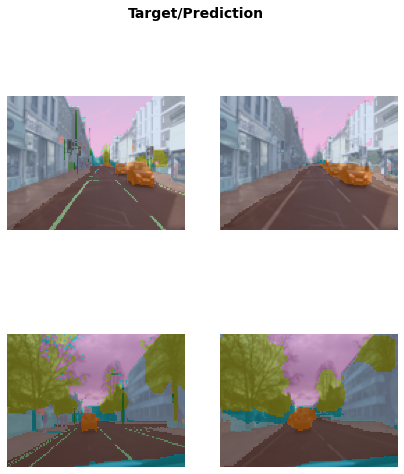

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

One other area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more. Here is all of the code necessary to train a model that can classify the sentiment of a movie review better than anything that existed in the world just five years ago:

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.878776,0.748753,0.500400,01:27


epoch,train_loss,valid_loss,accuracy,time
0,0.679118,0.674778,0.584040,02:45
1,0.653671,0.670396,0.618040,02:55
2,0.598665,0.551815,0.718920,05:28
3,0.556812,0.507450,0.752480,03:11


#clean
If you hit a "CUDA out of memory error" after running this cell, click on the menu Kernel, then restart. Instead of executing the cell above, copy and paste the following code in it:

```
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)
```

This reduces the batch size to 32 (we will explain this later). If you keep hitting the same error, change 32 to 16.

This model is using the ["IMDb Large Movie Review dataset"](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) from the paper "Learning Word Vectors for Sentiment Analysis" by Andrew Maas et al. It works well with movie reviews of many thousands of words, but let's test it out on a very short one to see how it does its thing:

In [ ]:
learn.predict("I really liked that movie!")

('neg', tensor(0), tensor([0.8786, 0.1214]))

Here we can see the model has considered the review to be positive. The second part of the result is the index of "pos" in our data vocabulary and the last part is the probabilities attributed to each class (99.6% for "pos" and 0.4% for "neg"). 

Now it's your turn! Write your own mini movie review, or copy one from the internet, and you can see what this model thinks about it. 

### Sidebar: The Order Matters

In a Jupyter notebook, the order in which you execute each cell is very important. It's not like Excel, where everything gets updated as soon as you type something anywhere—it has an inner state that gets updated each time you execute a cell. For instance, when you run the first cell of the notebook (with the "CLICK ME" comment), you create an object called `learn` that contains a model and data for an image classification problem. If we were to run the cell just shown in the text (the one that predicts if a review is good or not) straight after, we would get an error as this `learn` object does not contain a text classification model. This cell needs to be run after the one containing:

```python
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy)
learn.fine_tune(4, 1e-2)
```

The outputs themselves can be deceiving, because they include the results of the last time the cell was executed; if you change the code inside a cell without executing it, the old (misleading) results will remain.

Except when we mention it explicitly, the notebooks provided on the [book website](https://book.fast.ai/) are meant to be run in order, from top to bottom. In general, when experimenting, you will find yourself executing cells in any order to go fast (which is a super neat feature of Jupyter Notebook), but once you have explored and arrived at the final version of your code, make sure you can run the cells of your notebooks in order (your future self won't necessarily remember the convoluted path you took otherwise!). 

In command mode, pressing `0` twice will restart the *kernel* (which is the engine powering your notebook). This will wipe your state clean and make it as if you had just started in the notebook. Choose Run All Above from the Cell menu to run all cells above the point where you are. We have found this to be very useful when developing the fastai library.

### End sidebar

If you ever have any questions about a fastai method, you should use the function `doc`, passing it the method name:

```python
doc(learn.predict)
```

This will make a small window pop up with content like this:

<img src="images/doc_ex.png" width="600">

A brief one-line explanation is provided by `doc`. The "Show in docs" link takes you to the full documentation, where you'll find all the details and lots of examples. Also, most of fastai's methods are just a handful of lines, so you can click the "source" link to see exactly what's going on behind the scenes.

Let's move on to something much less sexy, but perhaps significantly more widely commercially useful: building models from plain *tabular* data.

> jargon: Tabular: Data that is in the form of a table, such as from a spreadsheet, database, or CSV file. A tabular model is a model that tries to predict one column of a table based on information in other columns of the table.

It turns out that looks very similar too. Here is the code necessary to train a model that will predict whether a person is a high-income earner, based on their socioeconomic background:

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

As you see, we had to tell fastai which columns are *categorical* (that is, contain values that are one of a discrete set of choices, such as `occupation`) and which are *continuous* (that is, contain a number that represents a quantity, such as `age`).

There is no pretrained model available for this task (in general, pretrained models are not widely available for any tabular modeling tasks, although some organizations have created them for internal use), so we don't use `fine_tune` in this case. Instead we use `fit_one_cycle`, the most commonly used method for training fastai models *from scratch* (i.e. without transfer learning):

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.372397,0.357177,0.832463,00:08
1,0.351544,0.341505,0.841523,00:08
2,0.338763,0.339184,0.845670,00:08


This model is using the [*Adult* dataset](http://robotics.stanford.edu/~ronnyk/nbtree.pdf), from the paper "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid" by Rob Kohavi, which contains some demographic data about individuals (like their education, marital status, race, sex, and whether or not they have an annual income greater than \$50k). The model is over 80\% accurate, and took around 30 seconds to train.

Let's look at one more. Recommendation systems are very important, particularly in e-commerce. Companies like Amazon and Netflix try hard to recommend products or movies that users might like. Here's how to train a model that will predict movies people might like, based on their previous viewing habits, using the [MovieLens dataset](https://doi.org/10.1145/2827872):

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.510897,1.410028,00:00


epoch,train_loss,valid_loss,time
0,1.375435,1.350930,00:00
1,1.270062,1.173962,00:00
2,1.023159,0.879298,00:00
3,0.797398,0.739787,00:00
4,0.685500,0.700903,00:00
5,0.646508,0.686387,00:00
6,0.623985,0.681087,00:00
7,0.606319,0.676885,00:00
8,0.606975,0.675833,00:00
9,0.602670,0.675682,00:00


This model is predicting movie ratings on a scale of 0.5 to 5.0 to within around 0.6 average error. Since we're predicting a continuous number, rather than a category, we have to tell fastai what range our target has, using the `y_range` parameter.

Although we're not actually using a pretrained model (for the same reason that we didn't for the tabular model), this example shows that fastai lets us use `fine_tune` anyway in this case (you'll learn how and why this works in <<chapter_pet_breeds>>). Sometimes it's best to experiment with `fine_tune` versus `fit_one_cycle` to see which works best for your dataset.

We can use the same `show_results` call we saw earlier to view a few examples of user and movie IDs, actual ratings, and predictions:

In [ ]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,66.0,79.0,4.0,3.978900
1,97.0,15.0,4.0,3.851795
2,55.0,79.0,3.5,3.945623
3,98.0,91.0,4.0,4.458704
4,53.0,7.0,5.0,4.670005
5,26.0,69.0,5.0,4.319870
6,81.0,16.0,4.5,4.426761
7,80.0,7.0,4.0,4.046183
8,51.0,94.0,5.0,3.499996


### Sidebar: Datasets: Food for Models

You’ve already seen quite a few models in this section, each one trained using a different dataset to do a different task. In machine learning and deep learning, we can’t do anything without data. So, the people that create datasets for us to train our models on are the (often underappreciated) heroes. Some of the most useful and important datasets are those that become important *academic baselines*; that is, datasets that are widely studied by researchers and used to compare algorithmic changes. Some of these become household names (at least, among households that train models!), such as MNIST, CIFAR-10, and ImageNet.

The datasets used in this book have been selected because they provide great examples of the kinds of data that you are likely to encounter, and the academic literature has many examples of model results using these datasets to which you can compare your work.

Most datasets used in this book took the creators a lot of work to build. For instance, later in the book we’ll be showing you how to create a model that can translate between French and English. The key input to this is a French/English parallel text corpus prepared back in 2009 by Professor Chris Callison-Burch of the University of Pennsylvania. This dataset contains over 20 million sentence pairs in French and English. He built the dataset in a really clever way: by crawling millions of Canadian web pages (which are often multilingual) and then using a set of simple heuristics to transform URLs of French content onto URLs pointing to the same content in English.

As you look at datasets throughout this book, think about where they might have come from, and how they might have been curated. Then think about what kinds of interesting datasets you could create for your own projects. (We’ll even take you step by step through the process of creating your own image dataset soon.)

fast.ai has spent a lot of time creating cut-down versions of popular datasets that are specially designed to support rapid prototyping and experimentation, and to be easier to learn with. In this book we will often start by using one of the cut-down versions and later scale up to the full-size version (just as we're doing in this chapter!). In fact, this is how the world’s top practitioners do their modeling in practice; they do most of their experimentation and prototyping with subsets of their data, and only use the full dataset when they have a good understanding of what they have to do.

### End sidebar

Each of the models we trained showed a training and validation loss. A good validation set is one of the most important pieces of the training process. Let's see why and learn how to create one.

## Validation Sets and Test Sets

As we've discussed, the goal of a model is to make predictions about data. But the model training process is fundamentally dumb. If we trained a model with all our data, and then evaluated the model using that same data, we would not be able to tell how well our model can perform on data it hasn’t seen. Without this very valuable piece of information to guide us in training our model, there is a very good chance it would become good at making predictions about that data but would perform poorly on new data.

To avoid this, our first step was to split our dataset into two sets: the *training set* (which our model sees in training) and the *validation set*, also known as the *development set* (which is used only for evaluation). This lets us test that the model learns lessons from the training data that generalize to new data, the validation data.

One way to understand this situation is that, in a sense, we don't want our model to get good results by "cheating." If it makes an accurate prediction for a data item, that should be because it has learned characteristics of that kind of item, and not because the model has been shaped by *actually having seen that particular item*.

Splitting off our validation data means our model never sees it in training and so is completely untainted by it, and is not cheating in any way. Right?

In fact, not necessarily. The situation is more subtle. This is because in realistic scenarios we rarely build a model just by training its weight parameters once. Instead, we are likely to explore many versions of a model through various modeling choices regarding network architecture, learning rates, data augmentation strategies, and other factors we will discuss in upcoming chapters. Many of these choices can be described as choices of *hyperparameters*. The word reflects that they are parameters about parameters, since they are the higher-level choices that govern the meaning of the weight parameters.

The problem is that even though the ordinary training process is only looking at predictions on the training data when it learns values for the weight parameters, the same is not true of us. We, as modelers, are evaluating the model by looking at predictions on the validation data when we decide to explore new hyperparameter values! So subsequent versions of the model are, indirectly, shaped by us having seen the validation data. Just as the automatic training process is in danger of overfitting the training data, we are in danger of overfitting the validation data through human trial and error and exploration.

The solution to this conundrum is to introduce another level of even more highly reserved data, the *test set*. Just as we hold back the validation data from the training process, we must hold back the test set data even from ourselves. It cannot be used to improve the model; it can only be used to evaluate the model at the very end of our efforts. In effect, we define a hierarchy of cuts of our data, based on how fully we want to hide it from training and modeling processes: training data is fully exposed, the validation data is less exposed, and test data is totally hidden. This hierarchy parallels the different kinds of modeling and evaluation processes themselves—the automatic training process with back propagation, the more manual process of trying different hyper-parameters between training sessions, and the assessment of our final result.

The test and validation sets should have enough data to ensure that you get a good estimate of your accuracy. If you're creating a cat detector, for instance, you generally want at least 30 cats in your validation set. That means that if you have a dataset with thousands of items, using the default 20% validation set size may be more than you need. On the other hand, if you have lots of data, using some of it for validation probably doesn't have any downsides.

Having two levels of "reserved data"—a validation set and a test set, with one level representing data that you are virtually hiding from yourself—may seem a bit extreme. But the reason it is often necessary is because models tend to gravitate toward the simplest way to do good predictions (memorization), and we as fallible humans tend to gravitate toward fooling ourselves about how well our models are performing. The discipline of the test set helps us keep ourselves intellectually honest. That doesn't mean we *always* need a separate test set—if you have very little data, you may need to just have a validation set—but generally it's best to use one if at all possible.

This same discipline can be critical if you intend to hire a third party to perform modeling work on your behalf. A third party might not understand your requirements accurately, or their incentives might even encourage them to misunderstand them. A good test set can greatly mitigate these risks and let you evaluate whether their work solves your actual problem.

To put it bluntly, if you're a senior decision maker in your organization (or you're advising senior decision makers), the most important takeaway is this: if you ensure that you really understand what test and validation sets are and why they're important, then you'll avoid the single biggest source of failures we've seen when organizations decide to use AI. For instance, if you're considering bringing in an external vendor or service, make sure that you hold out some test data that the vendor *never gets to see*. Then *you* check their model on your test data, using a metric that *you* choose based on what actually matters to you in practice, and *you* decide what level of performance is adequate. (It's also a good idea for you to try out some simple baseline yourself, so you know what a really simple model can achieve. Often it'll turn out that your simple model performs just as well as one produced by an external "expert"!)

### Use Judgment in Defining Test Sets

To do a good job of defining a validation set (and possibly a test set), you will sometimes want to do more than just randomly grab a fraction of your original dataset. Remember: a key property of the validation and test sets is that they must be representative of the new data you will see in the future. This may sound like an impossible order! By definition, you haven’t seen this data yet. But you usually still do know some things.

It's instructive to look at a few example cases. Many of these examples come from predictive modeling competitions on the [Kaggle](https://www.kaggle.com/) platform, which is a good representation of problems and methods you might see in practice.

One case might be if you are looking at time series data. For a time series, choosing a random subset of the data will be both too easy (you can look at the data both before and after the dates you are trying to predict) and not representative of most business use cases (where you are using historical data to build a model for use in the future). If your data includes the date and you are building a model to use in the future, you will want to choose a continuous section with the latest dates as your validation set (for instance, the last two weeks or last month of available data).

Suppose you want to split the time series data in <<timeseries1>> into training and validation sets.

<img src="images/timeseries1.png" width="400" id="timeseries1" caption="A time series" alt="A serie of values">

A random subset is a poor choice (too easy to fill in the gaps, and not indicative of what you'll need in production), as we can see in <<timeseries2>>.

<img src="images/timeseries2.png" width="400" id="timeseries2" caption="A poor training subset" alt="Random training subset">

Instead, use the earlier data as your training set (and the later data for the validation set), as shown in <<timeseries3>>.

<img src="images/timeseries3.png" width="400" id="timeseries3" caption="A good training subset" alt="Training subset using the data up to a certain timestamp">

For example, Kaggle had a competition to [predict the sales in a chain of Ecuadorian grocery stores](https://www.kaggle.com/c/favorita-grocery-sales-forecasting). Kaggle's training data ran from Jan 1 2013 to Aug 15 2017, and the test data spanned Aug 16 2017 to Aug 31 2017. That way, the competition organizer ensured that entrants were making predictions for a time period that was *in the future*, from the perspective of their model. This is similar to the way quant hedge fund traders do *back-testing* to check whether their models are predictive of future periods, based on past data.

A second common case is when you can easily anticipate ways the data you will be making predictions for in production may be *qualitatively different* from the data you have to train your model with.

In the Kaggle [distracted driver competition](https://www.kaggle.com/c/state-farm-distracted-driver-detection), the independent variables are pictures of drivers at the wheel of a car, and the dependent variables are categories such as texting, eating, or safely looking ahead. Lots of pictures are of the same drivers in different positions, as we can see in <<img_driver>>. If you were an insurance company building a model from this data, note that you would be most interested in how the model performs on drivers it hasn't seen before (since you would likely have training data only for a small group of people). In recognition of this, the test data for the competition consists of images of people that don't appear in the training set.

<img src="images/driver.PNG" width="600" id="img_driver" caption="Two pictures from the training data" alt="Two pictures from the training data, showing the same driver">

If you put one of the images in <<img_driver>> in your training set and one in the validation set, your model will have an easy time making a prediction for the one in the validation set, so it will seem to be performing better than it would on new people. Another perspective is that if you used all the people in training your model, your model might be overfitting to particularities of those specific people, and not just learning the states (texting, eating, etc.).

A similar dynamic was at work in the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) to identify the species of fish caught by fishing boats in order to reduce illegal fishing of endangered populations.  The test set consisted of boats that didn't appear in the training data.  This means that you'd want your validation set to include boats that are not in the training set.

Sometimes it may not be clear how your validation data will differ.  For instance, for a problem using satellite imagery, you'd need to gather more information on whether the training set just contained certain geographic locations, or if it came from geographically scattered data.

Now that you have gotten a taste of how to build a model, you can decide what you want to dig into next.

## A _Choose Your Own Adventure_ moment

If you would like to learn more about how to use deep learning models in practice, including how to identify and fix errors, create a real working web application, and avoid your model causing unexpected harm to your organization or society more generally, then keep reading the next two chapters. If you would like to start learning the foundations of how deep learning works under the hood, skip to <<chapter_mnist_basics>>. (Did you ever read _Choose Your Own Adventure_ books as a kid? Well, this is kind of like that… except with more deep learning than that book series contained.)

You will need to read all these chapters to progress further in the book, but it is totally up to you which order you read them in. They don't depend on each other. If you skip ahead to <<chapter_mnist_basics>>, we will remind you at the end to come back and read the chapters you skipped over before you go any further.

## Questionnaire

It can be hard to know in pages and pages of prose what the key things are that you really need to focus on and remember. So, we've prepared a list of questions and suggested steps to complete at the end of each chapter. All the answers are in the text of the chapter, so if you're not sure about anything here, reread that part of the text and make sure you understand it. Answers to all these questions are also available on the [book's website](https://book.fast.ai). You can also visit [the forums](https://forums.fast.ai) if you get stuck to get help from other folks studying this material.

For more questions, including detailed answers and links to the video timeline, have a look at Radek Osmulski's [aiquizzes](http://aiquizzes.com/howto).

1. Do you need these for deep learning?

   - Lots of math T / F
   - Lots of data T / F
   - Lots of expensive computers T / F
   - A PhD T / F
   
1. Name five areas where deep learning is now the best in the world.
1. What was the name of the first device that was based on the principle of the artificial neuron?
1. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?
1. What were the two theoretical misunderstandings that held back the field of neural networks?
1. What is a GPU?
1. Open a notebook and execute a cell containing: `1+1`. What happens?
1. Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.
1. Complete the Jupyter Notebook online appendix.
1. Why is it hard to use a traditional computer program to recognize images in a photo?
1. What did Samuel mean by "weight assignment"?
1. What term do we normally use in deep learning for what Samuel called "weights"?
1. Draw a picture that summarizes Samuel's view of a machine learning model.
1. Why is it hard to understand why a deep learning model makes a particular prediction?
1. What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?
1. What do you need in order to train a model?
1. How could a feedback loop impact the rollout of a predictive policing model?
1. Do we always have to use 224×224-pixel images with the cat recognition model?
1. What is the difference between classification and regression?
1. What is a validation set? What is a test set? Why do we need them?
1. What will fastai do if you don't provide a validation set?
1. Can we always use a random sample for a validation set? Why or why not?
1. What is overfitting? Provide an example.
1. What is a metric? How does it differ from "loss"?
1. How can pretrained models help?
1. What is the "head" of a model?
1. What kinds of features do the early layers of a CNN find? How about the later layers?
1. Are image models only useful for photos?
1. What is an "architecture"?
1. What is segmentation?
1. What is `y_range` used for? When do we need it?
1. What are "hyperparameters"?
1. What's the best way to avoid failures when using AI in an organization?

### Further Research

Each chapter also has a "Further Research" section that poses questions that aren't fully answered in the text, or gives more advanced assignments. Answers to these questions aren't on the book's website; you'll need to do your own research!

1. Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?
1. Try to think of three areas where feedback loops might impact the use of machine learning. See if you can find documented examples of that happening in practice.